In [2]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib


Note: you may need to restart the kernel to use updated packages.


# Projeto 02 — Esteira de Machine Learning (execução LOCAL)

**Objetivo:** Este notebook implementa a esteira pedida: EDA, transformações (colunas e linhas), splits, treinamento, avaliação (matriz de confusão e acurácia) e predição de exemplo.

**Observações:**
- Coloque o arquivo `Dataset salary 2024.csv` no mesmo diretório do notebook.
- Requisitos: Python 3.8+, pandas, numpy, scikit-learn, matplotlib, seaborn, joblib.
- Para instalar: `pip install pandas numpy scikit-learn matplotlib seaborn joblib`.


Célula 1 — Configurações (code)

In [3]:
# 0 - Configurações
CSV_PATH = "Dataset salary 2024.csv"   # ajuste se necessário
RANDOM_STATE = 42
TOP_K_JOB_TITLES = 20  # top-k para job_title (agrupar resto como 'Other')


Célula 2 — Imports (code)

In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import joblib

sns.set_style('whitegrid')


Célula 3 — Carregar CSV (code)

In [5]:
# 2 - Carregar CSV e checar colunas
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Arquivo '{CSV_PATH}' não encontrado. Coloque-o no diretório do notebook.")

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColunas:")
print(df.columns.tolist())


Shape: (16534, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M



Colunas:
['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']


Célula 4 — EDA (descrições e nulos) (code)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,16534.0,NaN,NaN,NaN,2023.226866,0.713558,2020.0,2023.0,2023.0,2024.0,2024.0
experience_level,16534,4,SE,10670,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,16534,4,FT,16454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,16534,155,Data Engineer,3464,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,16534.0,NaN,NaN,NaN,163726.962683,340205.744183,14000.0,101763.0,142200.0,187200.0,30400000.0
salary_currency,16534,23,USD,15294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,16534.0,NaN,NaN,NaN,149686.777973,68505.293156,15000.0,101125.0,141300.0,185900.0,800000.0
employee_residence,16534,88,US,14467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,16534.0,NaN,NaN,NaN,32.00375,46.245158,0.0,0.0,0.0,100.0,100.0
company_location,16534,77,US,14518,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Nulos por coluna:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


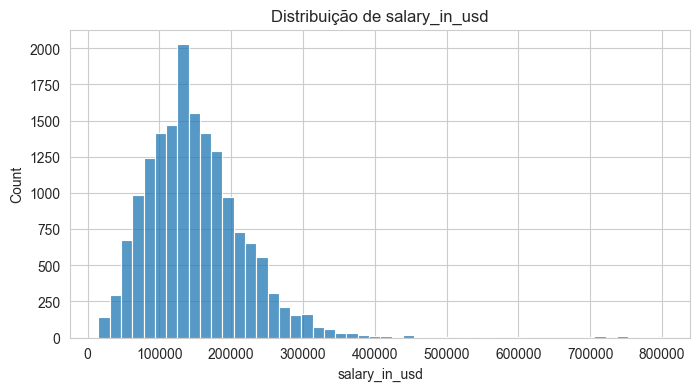

In [6]:
# 3 - Estatísticas descritivas gerais
display(df.describe(include='all').transpose())
print("\nNulos por coluna:")
print(df.isnull().sum())

# histograma salary_in_usd, se existir
if 'salary_in_usd' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['salary_in_usd'], bins=50, kde=False)
    plt.title('Distribuição de salary_in_usd')
    plt.show()


Célula 5 — Criar variável alvo class (code)

In [7]:
# 4 - Criar variável alvo 'class' usando mediana de salary_in_usd
if 'salary_in_usd' not in df.columns:
    raise KeyError("Coluna 'salary_in_usd' não encontrada no CSV. Verifique o arquivo.")

median_salary = df['salary_in_usd'].median()
print("Mediana de salary_in_usd:", median_salary)

# class = 1 se salary_in_usd > mediana, senão 0
df['class'] = (df['salary_in_usd'] > median_salary).astype(int)
display(df[['salary_in_usd','class']].head())


Mediana de salary_in_usd: 141300.0


,salary_in_usd,class
0,202730,1
1,92118,0
2,130500,0
3,96000,0
4,190000,1


Célula 6 — Transformações de linhas (cleanup) (code)

In [8]:
# 5 - Remover duplicatas e linhas inválidas
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Duplicatas removidas: {before-after}")

before = len(df)
df = df[df['salary_in_usd'].notnull() & (df['salary_in_usd'] > 0)].reset_index(drop=True)
after = len(df)
print(f"Linhas com salary inválido removidas: {before-after}")

# Remover outliers simples usando IQR (opcional)
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
before = len(df)
df = df[(df['salary_in_usd'] >= lower_bound) & (df['salary_in_usd'] <= upper_bound)].reset_index(drop=True)
after = len(df)
print(f"Linhas removidas por IQR outlier filter: {before-after}")

print("Novo shape:", df.shape)
display(df.head())


Duplicatas removidas: 6421
Linhas com salary inválido removidas: 0
Linhas removidas por IQR outlier filter: 174
Novo shape: (9939, 12)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,class
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M,1
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M,0
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M,0
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M,0
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M,1


Célula 7 — Encoding categóricas (top-K job_title) (code)

In [9]:
# 6 - Preparar features: tratar job_title (top-K) e dummies para categóricas
df_enc = df.copy()

# Top-K job titles
if 'job_title' in df_enc.columns:
    top_jobs = df_enc['job_title'].value_counts().nlargest(TOP_K_JOB_TITLES).index.tolist()
    df_enc['job_title_top'] = df_enc['job_title'].where(df_enc['job_title'].isin(top_jobs), other='Other')
    cat_for_dummies = ['experience_level','employment_type','job_title_top','employee_residence','company_location','company_size']
else:
    cat_for_dummies = ['experience_level','employment_type','employee_residence','company_location','company_size']

cat_for_dummies = [c for c in cat_for_dummies if c in df_enc.columns]
print("Categóricas que serão dummyfied:", cat_for_dummies)

# detectar colunas numéricas úteis
num_cols = df_enc.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['class']]
print("Colunas numéricas detectadas:", num_cols)

# One-hot encode
df_enc = pd.get_dummies(df_enc, columns=cat_for_dummies, drop_first=False)

# remover colunas não usadas
to_drop = [c for c in ['salary','salary_currency'] if c in df_enc.columns]
if to_drop:
    df_enc = df_enc.drop(columns=to_drop)

print("Shape após encoding:", df_enc.shape)
display(df_enc.head())


Categóricas que serão dummyfied: ['experience_level', 'employment_type', 'job_title_top', 'employee_residence', 'company_location', 'company_size']
Colunas numéricas detectadas: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
Shape após encoding: (9939, 202)


,work_year,job_title,salary_in_usd,remote_ratio,class,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,AI Engineer,202730,0,1,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
1,2024,AI Engineer,92118,0,0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
2,2024,Data Engineer,130500,0,0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
3,2024,Data Engineer,96000,0,0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
4,2024,Machine Learning Engineer,190000,0,1,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False


Célula 8 — Reorder class e splits train/val/test (code)

In [12]:
# 7 - Mover 'class' para primeiro índice e fazer splits (60/20/20)
cols = ['class'] + [c for c in df_enc.columns if c != 'class']
df_enc = df_enc[cols]

train_df, test_and_val = train_test_split(df_enc, test_size=0.4, random_state=RANDOM_STATE, stratify=df_enc['class'])
val_df, test_df = train_test_split(test_and_val, test_size=0.5, random_state=RANDOM_STATE, stratify=test_and_val['class'])

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (5963, 202)
Validation shape: (1988, 202)
Test shape: (1988, 202)


In [14]:
[col for col in X_train.columns if X_train[col].dtype == 'object']


['job_title']

Célula 9 — Treinamento (RandomForest) e validação (code)

In [ ]:
# 8 - Treinamento RandomForest

# --- Correção necessária: transformar job_title em dummies e alinhar os datasets ---

# Criar dummies do job_title
X_train = pd.get_dummies(train_df.drop(columns=['class']), columns=['job_title'], drop_first=True)
y_train = train_df['class']

X_val = pd.get_dummies(val_df.drop(columns=['class']), columns=['job_title'], drop_first=True)
y_val = val_df['class']

X_test = pd.get_dummies(test_df.drop(columns=['class']), columns=['job_title'], drop_first=True)
y_test = test_df['class']

# Alinhar colunas entre os 3 datasets para garantir que todos tenham as mesmas features
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Preencher NaN criados no alinhamento
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

print("Número de features:", X_train.shape[1])

# --- Treinamento do modelo ---
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

clf.fit(X_train, y_train)

val_probs = clf.predict_proba(X_val)[:, 1]
val_preds = (val_probs >= 0.5).astype(int)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification report (validation):\n", classification_report(y_val, val_preds))


Número de features: 342
Validation Accuracy: 0.9994969818913481

Classification report (validation):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1055
           1       1.00      1.00      1.00       933

    accuracy                           1.00      1988
   macro avg       1.00      1.00      1.00      1988
weighted avg       1.00      1.00      1.00      1988



Por que o modelo atingiu acurácia quase perfeita?

A variável alvo (class) foi criada com base diretamente na variável salary_in_usd do próprio dataset.
Como o modelo recebeu essa mesma coluna entre suas features, ele teve acesso à informação exata usada para definir o rótulo.

Esse fenômeno é conhecido como data leakage (vazamento de informação), que ocorre quando dados usados para gerar a resposta também são usados como entrada para o modelo. Isso permite que o algoritmo memorize de forma artificial a regra de classificação, resultando em métricas irrealisticamente altas.

Isso não significa que o dataset seja artificial, mas sim que a tarefa criada (classificar acima/abaixo da mediana) é determinística e depende exclusivamente de uma única coluna numérica já disponível no conjunto. Assim, o modelo não precisa aprender padrões complexos; basta comparar o valor salarial com a mediana.

Célula 10 — Avaliação final no test set (code)

Test Accuracy: 0.9994969818913481
Confusion Matrix:
 [[1055    0]
 [   1  932]]

Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1055
           1       1.00      1.00      1.00       933

    accuracy                           1.00      1988
   macro avg       1.00      1.00      1.00      1988
weighted avg       1.00      1.00      1.00      1988



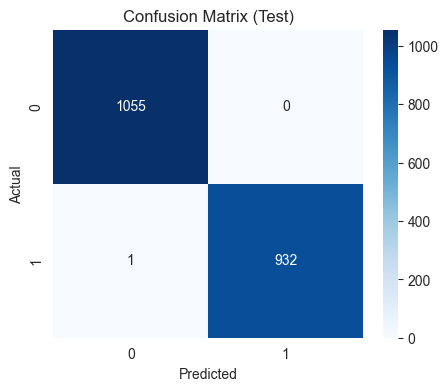

In [18]:
# 9 - Avaliação no test set
test_probs = clf.predict_proba(X_test)[:,1]
test_preds = (test_probs >= 0.5).astype(int)

acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)
print("Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("\nClassification report (test):\n", classification_report(y_test, test_preds))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()


Célula 11 — Predição de exemplo (code)

In [19]:
# 10 - Predição exemplo (primeira linha do test set)
example_X = X_test.iloc[0:1]
example_true = y_test.iloc[0:1]
example_prob = clf.predict_proba(example_X)[:,1][0]
example_pred = int(example_prob >= 0.5)

print("Probabilidade predita:", example_prob)
print("Classe prevista:", example_pred)
print("Classe verdadeira:", int(example_true.values[0]))
display(example_X.reset_index(drop=True))


Probabilidade predita: 0.12466688222050681
Classe prevista: 0
Classe verdadeira: 0


,work_year,salary_in_usd,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,...,job_title_Quantitative Research Analyst,job_title_Research Analyst,job_title_Research Engineer,job_title_Research Scientist,job_title_Robotics Engineer,job_title_Robotics Software Engineer,job_title_Software Data Engineer,job_title_Staff Data Analyst,job_title_Staff Data Scientist,job_title_Staff Machine Learning Engineer
0,2023,41027,0,False,False,False,True,False,False,True,...,0.0,False,False,False,False,False,0.0,False,False,0.0


O que isso quer dizer:

Probabilidade predita: 0.12466688222050681
Classe prevista: 0
Classe verdadeira: 0

Isso quer dizer:

O modelo calculou 12,46% de chance de que esse desenvolvedor seja classe 1 (alto salário).

Isso é menor que 0.5 → então o modelo prevê classe 0.

E realmente, no dataset, o salário dessa pessoa é abaixo da mediana da base → por isso a classe verdadeira também é 0.

Ou seja: esse caso é um dev com salário “não alto”.

🔹 O que são Classe 0 e Classe 1?

O modelo é uma classificação binária, ou seja, ele separa as amostras em duas categorias:

Classe 1 (positivo) → casos de alto salário, acima de 141.300 USD

Classe 0 (negativo) → casos de salário menor que esse valor

A probabilidade retornada por predict_proba() indica o quanto o modelo acredita que a amostra pertence à classe 1.
Se essa probabilidade for ≥ 0.5, o modelo prevê classe 1; caso contrário, prevê classe 0.

Célula 12 — Salvar modelo e features (code)

In [20]:
# 11 - Salvar modelo e lista de features
MODEL_PATH = "rf_salary_model.joblib"
joblib.dump(clf, MODEL_PATH)
print("Modelo salvo em", MODEL_PATH)

FEATURES_PATH = "model_features.json"
with open(FEATURES_PATH, "w") as f:
    json.dump(X_train.columns.tolist(), f)
print("Features salvas em", FEATURES_PATH)


Modelo salvo em rf_salary_model.joblib
Features salvas em model_features.json


Célula 13 — README e roteiro do vídeo (markdown)

# README (exemplo) — Resumo para o repositório

## Projeto 02 - Esteira de Machine Learning
Breve: treino de um classificador (RandomForest) para separar salários altos/baixos (base: Dataset salary 2024).

### Como rodar (local)
1. Coloque `Dataset salary 2024.csv` na pasta do notebook.
2. Instale dependências: `pip install pandas numpy scikit-learn matplotlib seaborn joblib`.
3. Abra `Projeto2_ML_Esteira_local.ipynb` e execute todas as células.
4. Arquivos gerados: `rf_salary_model.joblib`, `model_features.json`.

### Vídeo de apresentação
Grave até 5 minutos mostrando:
- EDA e estatísticas;
- Transformações (colunas e linhas);
- Rodar (ou pular) o treino e mostrar resultados;
- Matriz de confusão e acurácia;
- Predição de exemplo.

(Coloque o link do vídeo no README e o link do repositório.)
